# surrogate model and optimization

## build a surrogate model with neural network


### Data preprocessing


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df_dist = pd.read_csv('data/dis_23_forward_inputACT_abbc.csv')
df_strs = pd.read_csv('data/stress_cable_forward_inputACT_abbc.csv')
df = pd.concat([df_dist,df_strs], axis = 1)
# df = df.astype('float')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 45 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   n_step    100000 non-null  int64  
 1   ijk       100000 non-null  int64  
 2   num_load  100000 non-null  int64  
 3   A1        100000 non-null  float64
 4   A2        100000 non-null  float64
 5   A3        100000 non-null  float64
 6   A4        100000 non-null  float64
 7   Tup       100000 non-null  int64  
 8   Tmid      100000 non-null  int64  
 9   Tdown     100000 non-null  int64  
 10  23x       100000 non-null  object 
 11  23y       100000 non-null  object 
 12  23z       100000 non-null  object 
 13  1         100000 non-null  object 
 14  2         100000 non-null  object 
 15  3         100000 non-null  object 
 16  4         100000 non-null  object 
 17  5         100000 non-null  object 
 18  6         100000 non-null  object 
 19  7         100000 non-null  object 
 20  8    

In [4]:
pie = df.groupby('ijk')
pie.count()

,n_step,num_load,A1,A2,A3,A4,Tup,Tmid,Tdown,23x,...,23,24,25,26,27,28,29,30,31,32
ijk,,,,,,,,,,,,,,,,,,,,,
0,1860,1860,1860,1860,1860,1860,1860,1860,1860,1860,...,1860,1860,1860,1860,1860,1860,1860,1860,1860,1860
1,84621,84621,84621,84621,84621,84621,84621,84621,84621,84621,...,84621,84621,84621,84621,84621,84621,84621,84621,84621,84621
2,13519,13519,13519,13519,13519,13519,13519,13519,13519,13519,...,13519,13519,13519,13519,13519,13519,13519,13519,13519,13519


Text(0, 0.5, '')

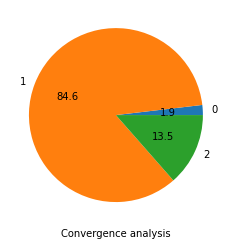

In [5]:
f = pie.count().num_load.plot.pie(autopct='%0.1f')
f.set_xlabel('Convergence analysis')
f.set_ylabel('')

### clustering
The displacement of Node 23 of both the converged and the failure solutions are drawn as a scatter plot in FigureXX.
Out of the 10,000 FEA simulations, there were over XXX failure cases. As shown in previous plots, these failures cases shows very different modes and thus are difficult to be excluded using simple constraints. 
However, judging by their speradic apperance it is nature to think to exclude these failure cases from the converged solutions by exploring their distinct density distribution.  
In this study we choose a unsupervised clustering algorithm called HDBSCAN - Hierarchical Density-Based Spatial Clustering of Applications with Noise.


HDBSCAN allows varying density clusters.
For details of the implementation of the HDBSCAN algorithm we refer the readers to the original paper[]. Here we just given the series of steps of the algorithsm.

1. Transform the space according to the density/sparsity.
2. Build the minimum spanning tree of the distance weighted graph.
3. Construct a cluster hierarchy of connected components.
4. Condense the cluster hierarchy based on minimum cluster size.
5. Extract the stable clusters from the condensed tree.

To our purpers, we see the failure cases as noise and we set the only model parameter minimal cluster size to be 40. As a result of the HDBSCAN the results are seperated into 3 groups: the majoritys which show a upward bending, the minority which bends downward and about 10% fairlure cases which shown as a noise group. The converged results from the first two group are selected to create the trainning dataset for the following machine learning model fitting. 


In [4]:
import plotly.express as px
import hdbscan

In [5]:
df_1 = df[df['ijk']==1]
df_1 = df_1.astype('float')

In [21]:
cond=((df_1.A1<0.1)&(df_1.A2<0.1)&(df_1.A3<0.1)&(df_1.A4<0.1))
cond.sum()
df_test=df_1[cond]
px.scatter_3d(df_test,x='23x',y='23y',z='23z')

In [26]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=40)
clusterer.fit(df_1[['23x','23y','23z']])
df_1['class'] = clusterer.labels_
df_1['class'] = df_1['class'].astype('category')
tmp=df_1.groupby('class')
tmp.count()
# display(tmp.count)
# f = tmp.count().num_load.plot.pie(autopct='%0.1f')



,n_step,ijk,num_load,A1,A2,A3,A4,Tup,Tmid,Tdown,...,23,24,25,26,27,28,29,30,31,32
class,,,,,,,,,,,,,,,,,,,,,
-1,5028,5028,5028,5028,5028,5028,5028,5028,5028,5028,...,5028,5028,5028,5028,5028,5028,5028,5028,5028,5028
0,65970,65970,65970,65970,65970,65970,65970,65970,65970,65970,...,65970,65970,65970,65970,65970,65970,65970,65970,65970,65970
1,13623,13623,13623,13623,13623,13623,13623,13623,13623,13623,...,13623,13623,13623,13623,13623,13623,13623,13623,13623,13623


In [27]:
sample_size = min(30_000,df_1.shape[0])

fig = px.scatter_3d(df_1.sample(sample_size),x='23x',y='23y',z='23z',color='class')

fig.update_traces(marker=dict(size=2,
                              line=dict(width=1,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers')
                  )
fig.show()

### Machine learning

Machine learning is getting more attention than ever in applied mechinical engineering. 
Scientific machine learning is the new trend. 
Bayesian inference and deep learning with neural network are very successful. 
Oden has demonstrated how Beyesian method can be used to combine experiment with mechanical models to create a framework for real time system dynamics prediction. 
WK law demonstrated how machine learning methods like neural network and Gaussian process regression model can be used in quantifing the uncertainties in dynamic system analysis. 
Depending on the nature of the problem studied and the size of the acquired database, there is no one machine learning method that can answer all the questions. 
In this work we compared two most popular methods, Gaussian process regression and neural networks, in uncertainty quantification for tensegrity. It should be pointed out that the comparison
we made is to demonstrate the difference of the methods, not to make recommandations. In fact we even have combined the two methods in attampt for a stochastic global optimization study.



### Gaussian Process regression

Gaussian process regression (GPR) is a type of Bayesian nonparametric regression method that allows flexible representation of the posterior distribution of an interest parameter. The most severe drawback of GPR is the computational cost, which is O(N3) for data size N.



Gaussian processes (GPs) are distributions over functions (Rasmussen and Williams, 2006), such that

f∼GP(ν(⋅),k(⋅,⋅)),		(1)
where ν:Rd→R is the mean function and k:Rd×Rd→R is the covariance function. Given an observed dataset D={X,y}={xi,yi}ni=1 with xi∈Rd, yi∈R, the posterior distribution of f={f(xi)}ni=1,f:Rd→R is stated as

(2)
where νX={ν(xi)}Ni=1, [KX,X′;θ]s,t=k(xs,x′t|θ), θ are the hyperparameters of the prior distributions, Λ={Λ(xi)}ni=1 are the parameters of the probability model except f,Λ:Rd→Rp−1, and p∈N is the number of parameters.

Training and Prediction. In the context of a GPR, our main concern is maximizing the log marginal likelihood

L(Λ,θ|D)=logP(y|X,Λ,θ)=log∫P(y|f,Λ)N(f|νX,KX,X;θ)df.		(3)
The hyperparameters are optimized as

Λ∗,θ∗=arg maxΛ,θL(Λ,θ|D).		(4)
If the probability model P(y|f,Λ) is Gaussian, then we can analytically obtain the gradient ∂L(Λ,θ|D)∂Λ,∂L(Λ,θ|D)∂θ for the optimization. The form of the log marginal likelihood is given as

Lnormal(Λ,θ|D)=−12(y−νX)TK−1(y−νX)−12log|K|−n2log(2π),		(5)
where K=KX,X;θ+Λ,Λ=σIn,0<σ∈R. In addition, the posterior distribution of f∗={f(x∗i)}n∗i=1 for a new input X∗={x∗i}n∗i=1 with x∗i∈Rd

is Gaussian. Further, its mean and variance are given as

E[f∗|D,X∗,θ∗,σ∗]	=νX∗+KX∗,X;θ∗(KX,X;θ∗+σ∗In)−1(y−νX),		(6)
Var[f∗|D,X∗,θ∗,σ∗]	=KX∗,X∗;θ∗+σ∗In∗−KX∗,X;θ∗(KX,X;θ∗+σ∗In)−1KX,X∗;θ∗,		(7)
where σ∗ is the optimized value of σ. Despite these simplifications, GPRs significantly contribute toward modeling various problems flexibly. However, the computational cost O(n3) for the inverse matrix computation K−1 is unacceptable from the view of scalability, and the probability model P(y|f,Λ) is unknown in some cases.

Covariance Function.

The radial basis function (RBF) kernel is a basic covariance function that can be written as

kRBF(xs,x′t|θ)≡Cexp(−12(xs−x′t)Tdiag(l)−2(xs−x′t)),		(8)
where θ={C,l},l={lj}dj=1,0<C,lj∈R for all j. The covariance functions can be designed flexibly by combining multiple simpler functions. For example, Lee et al. 2018

proved that a GP with a specific covariance function is equivalent to the function of a deep neural network with infinitely wide layers. However, the covariance functions are limited to positive semi-definite types, which sometimes prevent the ability to design them freely. The Euclidean distance space

(Rd,dE) between two points (xs,x′t) in the RBF kernel exp(−12dE(xs,x′t)2) cannot be replaced by an uneven distance space (Feragen et al., 2015), where dE:Rd×Rd→R. To address this, some works (Guhaniyogi and Dunson, 2016; Calandra et al., 2016) transformed the original feature space to a new space instead of designing the covariance function directly.

Since we are interested in establish a general framework for quantifying model uncertainty. In this work we are focusing on the the most foundamental uncertainty propagation theory and uncertainty distribution is accumulated by Monte Carlo simulations.

We noticed that GPR model can provide the distribution of the predicted values and it is widely used for uncertainty quantification. 
But here, the GPR is selected for its relative computation efficiency comparing to the full FEA model.
Only the Mean of the prediction is used for interpolating the mean value for point estimation.  

The advantage of being able to provide the distribution of the prediction is used to formulate a derivative free stochastic optimization in the following sections. 



### Neural network
A neural network in its most simple form consists of a single neuron, also called perceptron,
which maps the input vector x through a number of linear transformations onto the output ^y.
The mapping is achieved through the activation function σðx;w; b0Þ, where w is the node
weight vector and b0 the offset bias (one offset bias per neuron). Both are free parameters and
have to be found during the supervised learning process. Figure 2 illustrates how a perceptron
is working. All the inputs xi are multiplied with their respective weights wi and summed up.
Finally, the offset bias is added and shifts the decision boundary away from the origin.
The current state-of-the-art activation function is the rectified linear unit (ReLU) (Nair
and Hinton 2010). Stacking more neurons in parallel between input and output one obtains
a densely connected network. Densely means that every neuron is directly connected to
every neuron in the previous and subsequent layer. Increasing the number of layers between
input and output the network is commonly called a deep neural network (LeCun, Bengio,
Hinton 2015) where the output of each layer is fed as input into the next layer.
Prior to using the network for predictions in the so-called inference step, the free
parameters, i.e., the weight vector w and offset biases b0 of the nodes have to be optimized
during the network training procedure. This is commonly done as follows:
(a) The network is given a training data consisting of input and output vectors x and y; the
input x is propagated through the network to obtain the prediction y,
(b) the error (also called loss) between true output y and prediction ^y is measured by
a loss function Lðy;^yÞ,
(c) in the back propagation (Rumelhart, Hintont, Williams 1986) step, the loss is passed
reversely through the network and the partial derivatives of the loss function w.r.t. to the
weights in the network are numerically computed, i.e., @Lðy;^yðwÞÞÞ
@w .
(d) In the optimization step the weights are updated according to the gradient descent method

In this study a nerual network with 2 hidden layers, each hidden layer has 50 neurons, were constructed. Mean square errors is selected as the loss function.
During the training phase, a two stage optimization strategy is adopted. The Neural network model is first trained with Adam optimization method for 500 iterations. 
As a adaptive method, Adam ensures fast convergence at the early stage of the model fitting. At the same time, the stochastic nature of the Adam algrorithsm can effectively 
avoid the model been trapped in a local optimal. In the second stage, a derivative based BFGS optimization is used
to further improve the accuracy of the model fitting. 

In [28]:
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt


In [29]:
cond = df_1['class']==0
df_train = df_1[cond]
fig = px.scatter_3d(df_train.sample(1000),x='23x',y='23y',z='23z')
fig.update_traces(marker=dict(size=2,
                              line=dict(width=1,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers')
                  )
fig.show()

In [11]:
df_train.to_csv('abbc.csv')

In [12]:
px.scatter_3d(df_train.sample(1000),x='A1',y='A2',z='A4',color='23z')

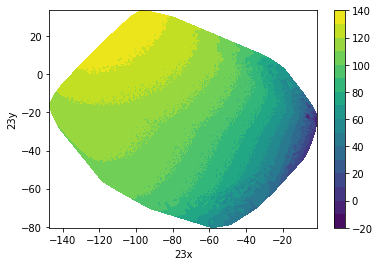

In [8]:
import itertools
import matplotlib.pyplot as plt



plt.figure()
# plt.tricontour(tmp[xLabel],tmp[yLabel], z, 15, linewidths=0.1, colors='k')
plt.tricontourf(df_train['23x'],df_train['23y'],df_train['23z'], 15)
plt.xlabel('23x')
plt.ylabel('23y')
plt.colorbar()

In [30]:
x_label=['A1','A2','A4']
X = df_train[x_label]

y_label = ['23x','23y','23z']
Y = df_train[y_label]

input_scaler = MinMaxScaler()
output_scaler = MinMaxScaler()

# input_scaler = StandardScaler()
# output_scaler = StandardScaler()import itertools

x = input_scaler.fit_transform(X)
y = output_scaler.fit_transform(Y)

In [65]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.1, random_state=42)


#### Model designe

In [66]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units=5,activation = 'relu', input_dim=x.shape[1]))
model.add(tf.keras.layers.Dense(units=50,activation = 'relu'))
model.add(tf.keras.layers.Dense(units=50,activation = 'relu'))
model.add(tf.keras.layers.Dense(units=y.shape[1],activation = 'linear'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 5)                 20        
_________________________________________________________________
dense_17 (Dense)             (None, 50)                300       
_________________________________________________________________
dense_18 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_19 (Dense)             (None, 3)                 153       
Total params: 3,023
Trainable params: 3,023
Non-trainable params: 0
_________________________________________________________________


In [68]:
def scheduler(epoch, lr):
  if epoch < 400:
    return lr
  else:
    # return lr * tf.math.exp(-0.1)
    return lr * 0.1

callback_rate = tf.keras.callbacks.LearningRateScheduler(scheduler)
callback_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100,restore_best_weights=True)

model.compile(optimizer='adam', loss='mse')
# model.compile(optimizer='sgd', loss='mse')

model.fit(
    x_train,
    y_train,
    epochs=600,
    validation_split=0.1,
    callbacks=[callback_early,callback_rate],
    batch_size=1024)

# model.compile(optimizer='sgd', loss='mse')
history = model.fit(
    x_train,
    y_train,
    epochs=600,
    validation_split=0.1,
    callbacks=[callback_early,callback_rate],
    batch_size=256)
model.save('models/act_abbc_nn.h5')

Epoch 1/600
53/53 [==============================] - 1s 5ms/step - loss: 1.7882e-04 - val_loss: 3.3423e-05
Epoch 2/600
53/53 [==============================] - 0s 3ms/step - loss: 3.4262e-05 - val_loss: 3.2839e-05
Epoch 3/600
53/53 [==============================] - 0s 2ms/step - loss: 3.5491e-05 - val_loss: 3.2736e-05
Epoch 4/600
53/53 [==============================] - 0s 2ms/step - loss: 3.7242e-05 - val_loss: 3.7958e-05
Epoch 5/600
53/53 [==============================] - 0s 2ms/step - loss: 3.5107e-05 - val_loss: 3.5037e-05
Epoch 6/600
53/53 [==============================] - 0s 3ms/step - loss: 3.7074e-05 - val_loss: 4.0177e-05
Epoch 7/600
53/53 [==============================] - 0s 3ms/step - loss: 3.8457e-05 - val_loss: 3.3088e-05
Epoch 8/600
53/53 [==============================] - 0s 2ms/step - loss: 3.0958e-05 - val_loss: 3.3186e-05
Epoch 9/600
53/53 [==============================] - 0s 3ms/step - loss: 3.7164e-05 - val_loss: 3.1372e-05
Epoch 10/600
53/53 [=================

In [69]:
y_predict = model.predict(x_test,batch_size=1024)
df_predict = pd.DataFrame(output_scaler.inverse_transform(y_predict), columns=y_label)
df_test = pd.DataFrame(output_scaler.inverse_transform(y_test), columns=y_label)

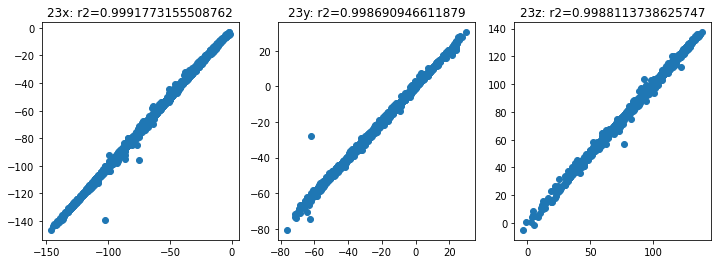

In [70]:
plt.figure(figsize=(12, 4))
for i,out in enumerate(y_label):
    plt.subplot(1,3,i+1)
    plt.scatter(df_predict[out], df_test[out])
    plt.title(f'{out}: r2={r2_score(df_predict[out], df_test[out])}')

## Optimization

The surogate model achieved through machine learning provides a efficient way for evaluation of the structure response to inputs. 
Such efficiecy allows for global optima investigation as well as invers type problem study via optimization algorithms. 
In the following section we will show how the neural network model is helping finding the actuaction for maximam displacement for the end node. 
To demonstrate the flexibility of such combination, we also studied an inverse problem. When the displacement is limited to only in z direction, how the actucation should be given?



### Search for max 23z while keeping 23y smaller than 1

Here the Sequential (least-squares) quadratic programming (SQP) algorithm is selected for this non-linear contrained and bounded problem.

Considering a general nonlinear optimization problem (NLP) of the form






$$
\begin{aligned}
minimize~~~~~~~~&f(x) \\
over~&x \in R^n \\
subject~to~& h(x)=0 \\
&g(x)<=0,
\end{aligned}
$$
where $f:R^n$ is the objective functional, $h:R^n->R^m$ and $g:R^n->R^p$ describe the constaints.

The algorithm optimizes successive second-order (quadratic/least-squares) approximations of the objective function (via BFGS updates), with first-order (affine) approximations of the constraints.
The general formulation can ben given as
$$
\begin{aligned}
minimize~~~~~~~~~~~~ &\nabla f(x^k)^Td(x) + \frac{1}{2}d(x)^TB_kd(x) \\
over~~~~~~&d(x) \in R^n \\
subject~to~~~~~~~ &h(x^k)+\nabla h(x^k)^Td(x)=0 \\
&g(x^k)+\nabla g(x^k)^Td(x)<= 0, \\


where,~~~~~~ &d(x)=x-x^k, B_k = Hf(x^k)

\end{aligned}
$$


$Hf(x^k)$ refers to the Hessian Matrix evaluated at $x^k \in R^n$. 


References
Dieter Kraft, ``A software package for sequential quadratic programming'', Technical Report DFVLR-FB 88-28, Institut fuer Dynamik der Flugsysteme, Oberpfaffenhofen, July 1988.

[refs](https://nlopt.readthedocs.io/en/latest/NLopt_Algorithms/#slsqp)

In this paper we chose the second order 

In [31]:
import tensorflow as tf
import numpy as np
from scipy.optimize import minimize

In [32]:
model = tf.keras.models.load_model('models/act_abbc_nn.h5')

def nn_pred(x):
    out = model.predict(input_scaler.transform(x.reshape(1,-1)))
    out = output_scaler.inverse_transform(out)
    return out




In [33]:
def obj(x):
    out=nn_pred(x)
    return -out[0,2]

def constraint(x):
    out = nn_pred(x)
    return 1 - abs(out[0,1])

cons = ({'type': 'ineq', 'fun': lambda x:1-abs(nn_pred(x)[0,1])})
# cons = ({'type': 'eq', 'fun': lambda x:abs(nn_pred(x)[0,1])})

In [47]:
x0=np.asarray([0.1,0.1,0.1]).reshape(1,-1)
sols = []
x_evl = []
trials = 20
for i in range(trials):
    print(f'{i/trials}')
    x0=np.random.uniform(0.05,0.3,3).reshape(1,-1)

    history = []
    
    def callback(x):
        fobj = obj(x)
        history.append(fobj)
        x_evl.append(x)


    sol = minimize(
        obj, x0, bounds=(
            (0.05, 0.3),
            # (0.05, 0.3),
            (0.05, 0.3),
            (0.05, 0.3)),
        # constraints=cons, 
        method = 'SLSQP',
        # method = 'L-BFGS-B',
        options={
            'disp': False, 'maxiter': 200}, callback=callback)

    # sol
    sols.append(sol)
sol

0.0
0.05
0.1
0.15
0.2
0.25


c:\Users\EDISON-G\Desktop\vscodeDebug\env\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning:

Values in x were outside bounds during a minimize step, clipping to bounds

c:\Users\EDISON-G\Desktop\vscodeDebug\env\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning:

Values in x were outside bounds during a minimize step, clipping to bounds



0.3


c:\Users\EDISON-G\Desktop\vscodeDebug\env\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning:

Values in x were outside bounds during a minimize step, clipping to bounds



0.35


c:\Users\EDISON-G\Desktop\vscodeDebug\env\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning:

Values in x were outside bounds during a minimize step, clipping to bounds



0.4


c:\Users\EDISON-G\Desktop\vscodeDebug\env\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning:

Values in x were outside bounds during a minimize step, clipping to bounds

c:\Users\EDISON-G\Desktop\vscodeDebug\env\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning:

Values in x were outside bounds during a minimize step, clipping to bounds



0.45


c:\Users\EDISON-G\Desktop\vscodeDebug\env\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning:

Values in x were outside bounds during a minimize step, clipping to bounds

c:\Users\EDISON-G\Desktop\vscodeDebug\env\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning:

Values in x were outside bounds during a minimize step, clipping to bounds



0.5
0.55


c:\Users\EDISON-G\Desktop\vscodeDebug\env\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning:

Values in x were outside bounds during a minimize step, clipping to bounds



0.6
0.65


c:\Users\EDISON-G\Desktop\vscodeDebug\env\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning:

Values in x were outside bounds during a minimize step, clipping to bounds



0.7
0.75
0.8
0.85
0.9


c:\Users\EDISON-G\Desktop\vscodeDebug\env\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning:

Values in x were outside bounds during a minimize step, clipping to bounds



0.95


     fun: -72.051956
     jac: array([0., 0., 0.])
 message: 'Optimization terminated successfully'
    nfev: 37
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([0.11788011, 0.13203708, 0.17169257])

In [43]:
funs = [sol.fun for sol in sols]
# display(funs)
# np.asarray([sol.nfev for sol in sols]).mean()

In [49]:
# sols[0].x
[(sol.x.round(3),sol.fun) for sol in sols]

[(array([0.077, 0.275, 0.104]), 58.54941177368164),
 (array([0.217, 0.258, 0.19 ]), -120.2316),
 (array([0.299, 0.3  , 0.264]), -121.39981),
 (array([0.137, 0.3  , 0.3  ]), -110.308495),
 (array([0.3 , 0.3 , 0.05]), -137.98691),
 (array([0.3  , 0.218, 0.25 ]), -117.26879),
 (array([0.143, 0.255, 0.247]), -110.46292),
 (array([0.156, 0.225, 0.201]), -105.72485),
 (array([0.209, 0.281, 0.205]), -118.335686),
 (array([0.276, 0.263, 0.276]), -115.95164),
 (array([0.226, 0.156, 0.051]), -91.63719940185547),
 (array([0.082, 0.261, 0.275]), -104.138336),
 (array([0.177, 0.172, 0.159]), -95.62532),
 (array([0.256, 0.3  , 0.19 ]), -128.36217),
 (array([0.3 , 0.3 , 0.05]), -137.95596),
 (array([0.257, 0.208, 0.226]), -114.256615),
 (array([0.163, 0.174, 0.29 ]), -94.74669647216797),
 (array([0.061, 0.137, 0.274]), -75.90211),
 (array([0.197, 0.098, 0.217]), -75.49693),
 (array([0.118, 0.132, 0.172]), -72.051956)]

In [14]:
df_tmp = pd.DataFrame(np.asarray(x_evl),columns=['A1','A23','A4'])
df_tmp.head(5)


,A1,A23,A4
0,0.30000,0.300000,0.100000
1,0.05000,0.300000,0.050000
2,0.05000,0.050000,0.050000
3,0.29989,0.299943,0.099978


In [15]:
px.scatter_3d(df_tmp,x='A1',y='A23',z='A4')

In [16]:
for i in sols:
    print(i.fun)

-140.44696


In [26]:
history

[-103.60774, -103.60774]

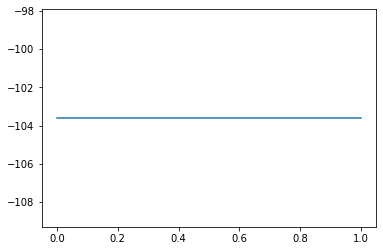

In [27]:
plt.plot([ x for x in history])

In [17]:
opt_x = np.asarray([sol.x[0],sol.x[1],sol.x[1],sol.x[2]]).reshape(1,-1)
np.savetxt("output/inputACT_abbc.csv",opt_x,delimiter=',')
print(f'input for optimal solution is {opt_x}')
print(f'optimal solution is {nn_pred(sol.x)}')


input for optimal solution is [[0.29988982 0.29994304 0.29994304 0.09997797]]
optimal solution is [[-115.147964   24.479382  140.44696 ]]


### Searching for z/y ratio


In [49]:
def obj_zy(x):
    out=nn_pred(x)
    return -abs(out[0,2])/(abs(out[0,1])+50)

def constraint(x):
    out = nn_pred(x)
    return 1 - abs(out[0,1])

cons = ({'type': 'ineq', 'fun': lambda x:1-abs(nn_pred(x)[0,1])})
# cons = ({'type': 'eq', 'fun': lambda x:abs(nn_pred(x)[0,1])})

In [50]:
# x0=np.asarray([0.1,0.1,0.1]).reshape(1,-1)
sols = []
x_evl = []
for i in range(5):
    x0=np.random.uniform(0.05,0.3,3).reshape(1,-1)

    history = []
    
    def callback(x):
        fobj = obj(x)
        history.append(fobj)
        x_evl.append(x)


    sol = minimize(
        obj_zy, x0, bounds=(
            (0.05, 0.3),
            # (0.05, 0.3),
            (0.05, 0.3),
            (0.05, 0.3)),
        # constraints=cons, 
        method = 'SLSQP',
        # method = 'L-BFGS-B',
        options={
            'disp': False, 'maxiter': 200}, callback=callback)

    # sol
    sols.append(sol)

c:\Users\EDISON-G\Desktop\vscodeDebug\env\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning:

Values in x were outside bounds during a minimize step, clipping to bounds

c:\Users\EDISON-G\Desktop\vscodeDebug\env\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning:

Values in x were outside bounds during a minimize step, clipping to bounds

c:\Users\EDISON-G\Desktop\vscodeDebug\env\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning:

Values in x were outside bounds during a minimize step, clipping to bounds

c:\Users\EDISON-G\Desktop\vscodeDebug\env\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning:

Values in x were outside bounds during a minimize step, clipping to bounds

c:\Users\EDISON-G\Desktop\vscodeDebug\env\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning:

Values in x were outside bounds during a minimize step, clipping to bounds

c:\Users\EDISON-G\Desktop\vscodeDebug\env\lib\site-packages\scipy\optimize\

In [51]:
for i in sols:
    print(i.fun)

-2.6085116918744964
-1.815173994962331
-0.8642077088742235
-2.4798266738469255
-2.537082757868774


### searching for multiple optimal solutions

In [89]:
obj_z = [80, 90, 100, 110, 120]
delta = 5

x0 = np.asarray([0.05, 0.05, 0.05]).reshape(1, -1)

solutions = []


for i in obj_z:
    print(f'i={i}')

    def obj_y(x):
        out = nn_pred(x)
        return abs(out[0, 1])

    cons = ({'type': 'ineq', 'fun': lambda x: nn_pred(x)[0, 2]-(i-delta)},
            {'type': 'ineq', 'fun': lambda x: (i + delta) - nn_pred(x)[0, 2]},
            )
    # cons = ({'type': 'eq', 'fun': lambda x: i - nn_pred(x)[0, 2]})
    sol = minimize(
        obj_y, x0, bounds=(
            (0.05, 0.3),
            # (0.05, 0.3),
            (0.05, 0.3),
            (0.05, 0.3)),
        constraints=cons, options={
            'disp': True, 'maxiter': 200})
    print(nn_pred(sol.x))
    solutions.append(sol)

i=80
Optimization terminated successfully    (Exit mode 0)
            Current function value: 26.61732
            Iterations: 11
            Function evaluations: 92
            Gradient evaluations: 11
[[-34.155487 -26.61732   77.68113 ]]
i=90


c:\Users\EDISON-G\Desktop\vscodeDebug\env\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning:

Values in x were outside bounds during a minimize step, clipping to bounds

c:\Users\EDISON-G\Desktop\vscodeDebug\env\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning:

Values in x were outside bounds during a minimize step, clipping to bounds

c:\Users\EDISON-G\Desktop\vscodeDebug\env\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning:

Values in x were outside bounds during a minimize step, clipping to bounds

c:\Users\EDISON-G\Desktop\vscodeDebug\env\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning:

Values in x were outside bounds during a minimize step, clipping to bounds

c:\Users\EDISON-G\Desktop\vscodeDebug\env\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning:

Values in x were outside bounds during a minimize step, clipping to bounds

c:\Users\EDISON-G\Desktop\vscodeDebug\env\lib\site-packages\scipy\optimize\

Optimization terminated successfully    (Exit mode 0)
            Current function value: 11.289804
            Iterations: 21
            Function evaluations: 140
            Gradient evaluations: 18
[[-42.492115  11.289804  93.00202 ]]
i=100
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.7084146
            Iterations: 10
            Function evaluations: 58
            Gradient evaluations: 9
[[-51.80816    -1.7084146 102.99982  ]]
i=110


c:\Users\EDISON-G\Desktop\vscodeDebug\env\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning:

Values in x were outside bounds during a minimize step, clipping to bounds

c:\Users\EDISON-G\Desktop\vscodeDebug\env\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning:

Values in x were outside bounds during a minimize step, clipping to bounds

c:\Users\EDISON-G\Desktop\vscodeDebug\env\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning:

Values in x were outside bounds during a minimize step, clipping to bounds



Inequality constraints incompatible    (Exit mode 4)
            Current function value: 36.761726
            Iterations: 17
            Function evaluations: 145
            Gradient evaluations: 15
[[-60.569927 -36.761726  79.53524 ]]
i=120


c:\Users\EDISON-G\Desktop\vscodeDebug\env\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning:

Values in x were outside bounds during a minimize step, clipping to bounds



Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.0004925089
            Iterations: 14
            Function evaluations: 101
            Gradient evaluations: 13
[[-9.3371643e+01 -4.9250887e-04  1.2453461e+02]]


### Bayesian optimization

![](https://gimg2.baidu.com/image_search/src=http%3A%2F%2Fupload-images.jianshu.io%2Fupload_images%2F16313196-aff2952b331baa7d.png%3FimageMogr2%2Fauto-orient%2Fstrip%257CimageView2%2F2%2Fw%2F1240&refer=http%3A%2F%2Fupload-images.jianshu.io&app=2002&size=f9999,10000&q=a80&n=0&g=0n&fmt=jpeg?sec=1620735560&t=04b118685a5c49734ff23c57c7b5255e)

Bayesian optimization  attempt to find the global optimimum in a minimum number of steps. Bayesian optimization incorporates prior belief about f and updates the prior with samples drawn from f to get a posterior that better approximates f. The model used for approximating the objective function is called surrogate model. Bayesian optimization also uses an acquisition function that directs sampling to areas where an improvement over the current best observation is likely.

Here Gaussian processes regression is selected as the surrogate model. GPs define a prior over functions and we can use them to incorporate prior beliefs about the objective function (smoothness, …). The GP posterior is cheap to evaluate and is used to propose points in the search space where sampling is likely to yield an improvement. Proposing sampling points in the search space is done by acquisition functions. They trade off exploitation and exploration. Exploitation means sampling where the surrogate model predicts a high objective and exploration means sampling at locations where the prediction uncertainty is high. Both correspond to high acquisition function values and the goal is to maximize the acquisition function to determine the next sampling point.

More formally, the objective function f will be sampled at xt=argmaxxu(x|D1:t−1) where u is the acquisition function and D1:t−1=(x1,y1),…,(xt−1,yt−1) are the t−1 samples drawn from f so far. Popular acquisition functions are maximum probability of improvement (MPI), expected improvement (EI) and upper confidence bound (UCB)[1]. In the following, we will use the expected improvement (EI) which is most widely used and described further below.

Expected improvement is defined as
EI(x)=Emax(f(x)−f(x+),0)(1)
where f(x+) is the value of the best sample so far and x+ is the location of that sample i.e. x+=argmaxxi∈x1:tf(xi). The expected improvement can be evaluated analytically under the GP model[3]:

EI(x)={(μ(x)−f(x+)−ξ)Φ(Z)+σ(x)ϕ(Z)0if σ(x)>0if σ(x)=0(2)
where

Z={μ(x)−f(x+)−ξσ(x)0if σ(x)>0if σ(x)=0
where μ(x) and σ(x) are the mean and the standard deviation of the GP posterior predictive at x, respectively. Φ and ϕ are the CDF and PDF of the standard normal distribution, respectively. The first summation term in Equation (2) is the exploitation term and second summation term is the exploration term.

Parameter ξ in Equation (2) determines the amount of exploration during optimization and higher ξ values lead to more exploration. In other words, with increasing ξ values, the importance of improvements predicted by the GP posterior mean μ(x) decreases relative to the importance of potential improvements in regions of high prediction uncertainty, represented by large σ(x) values. A recommended default value for ξ is 0.01.

Optimization algorithm
The Bayesian optimization procedure is as follows. For t=1,2,… repeat:

Find the next sampling point xt by optimizing the acquisition function over the GP: xt=argmaxxu(x|D1:t−1)
Obtain a possibly noisy sample yt=f(xt)+ϵt from the objective function f.
Add the sample to previous samples D1:t=D1:t−1,(xt,yt) and update the GP.




In [41]:
from skopt import gp_minimize

In [42]:
model = tf.keras.models.load_model('models/act_abbc_nn.h5')

def nn_pred(x):
    out = model.predict(input_scaler.transform(np.asarray(x).reshape(1,-1)))
    out = output_scaler.inverse_transform(out)
    return out

def obj_gp(x):
    # return x[0]+x[1]+x[2]
    return -nn_pred(x)[0,2]

def obj_gp_zy(x):
    # return -abs(nn_pred(x)[0,2])/(abs(nn_pred(x)[0,1])+50)
    return -abs(nn_pred(x)[0,2])/(abs(nn_pred(x)[0,1])+abs(nn_pred(x[0,2])))



In [43]:
res = gp_minimize(obj_gp,
                 [(0.05,0.3),(0.05,0.3),(0.05,0.3)],
                 acq_func='EI',
                 n_calls=50)

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

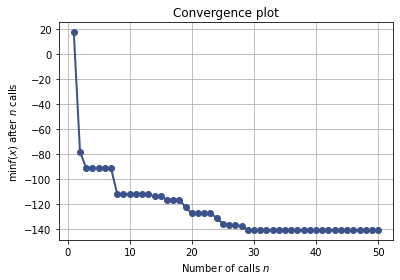

In [44]:
from skopt.plots import plot_convergence
plot_convergence(res)

In [45]:
res

          fun: -140.80943
    func_vals: array([  17.589367,  -78.126114,  -91.30756 ,  -49.474617,   54.827393,
        -87.81895 ,  -23.26624 , -112.34192 ,  -23.300936,  -14.06666 ,
       -110.28172 , -110.55611 ,  -59.83114 , -113.87879 , -113.15243 ,
       -116.55011 , -115.616714, -113.31461 , -122.77234 , -127.51456 ,
        -69.65618 , -108.579636, -126.39483 , -131.17366 , -135.82336 ,
       -137.09108 , -107.91592 , -137.50958 , -140.75824 , -129.81624 ,
        -29.47018 , -139.05486 , -132.32079 , -138.5953  ,  -79.53449 ,
       -104.47848 , -112.99533 , -114.98596 , -140.80943 , -132.16167 ,
       -133.9085  , -116.47779 , -140.23447 , -125.98114 , -113.6174  ,
        -95.81995 ,   81.40931 , -130.48943 , -107.91193 ,  -55.859264],
      dtype=float32)
       models: [GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1, 1], nu=2.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2, noise='gaussian',
                         n

In [114]:
df_gp = pd.DataFrame(np.asarray(res.x_iters),columns=['A1','A23','A4'])

In [115]:
px.scatter_3d(df_gp,x='A1',y='A23',z='A4')

In [20]:
res = gp_minimize(obj_gp_zy,
                 [(0.05,0.3),(0.05,0.3),(0.05,0.3)],
                 acq_func='EI',
                 n_calls=100)

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

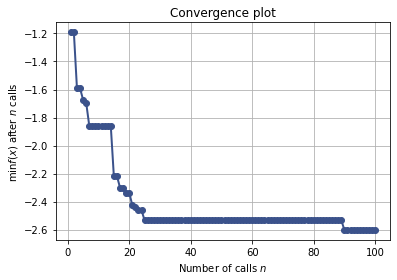

In [21]:
from skopt.plots import plot_convergence
plot_convergence(res)

In [25]:
opt_x = np.asarray([res.x[0],res.x[1],res.x[1],res.x[2]]).reshape(1,-1)
np.savetxt("output/inputACT_abbc_zy_ratio.csv",opt_x,delimiter=',')
print(f'input for optimal solution is {opt_x}')
print(f'optimal solution is {nn_pred(res.x)}')

input for optimal solution is [[0.27634636 0.3        0.3        0.18781313]]
optimal solution is [[-1.3216864e+02  6.9377221e-02  1.3027536e+02]]


In [24]:
nn_pred(res.x)

array([[-1.3216864e+02,  6.9377221e-02,  1.3027536e+02]], dtype=float32)

## Monte Carlo Uncertainty propagation

Monte Carlo simulations for uncertainty propagation take as inputs the uncertainty distribution for each variable and an equation for the calculation of a desired quantity. The desired quantity is then calculated by randomly drawing from the specified uncertainty distributions of the input variables. This calculation is then repeated many times (often 106 or greater) with new random drawings each time. The resulting uncertainty distribution of the calculated value is directly obtained from the many random trials. Monte Carlo uncertainty propagation has the advantage of both being easy to interpret and allowing for a wide variety of uncertainty distributions. 

![monte carlo](https://xpic.x-mol.com/20200513%2F10.1021_acs.jchemed.0c00096.gif)


[ref](https://pubs.acs.org/doi/full/10.1021/acs.jchemed.0c00096)

In [24]:
model = tf.keras.models.load_model('models/act_abbc_nn.h5')

def nn_mcs(x):
    out = model.predict(input_scaler.transform(x),batch_size=1024)
    out = output_scaler.inverse_transform(out)
    return out

In [31]:
sample_size = 10000
a = np.random.uniform(0.09,0.1,sample_size)
b = np.random.normal(0.09,0.01,sample_size)
c = np.random.uniform(0.09,0.1,sample_size)

<AxesSubplot:>

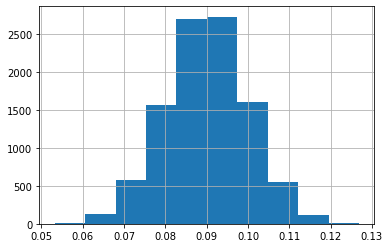

In [32]:
err_in = np.vstack([a,b,b,c])
df_err_in = pd.DataFrame(err_in.T,columns=["A1","A2","A3","A4"])
df_err_in['A2'].hist()

<AxesSubplot:>

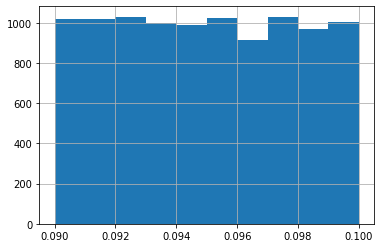

In [33]:
df_err_in['A1'].hist()

<AxesSubplot:>

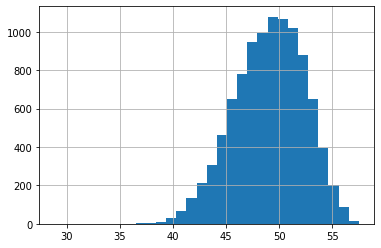

In [34]:
df_mcs_out = pd.DataFrame(nn_mcs(df_err_in[x_label]),columns=y_label)
df_mcs_out['23z'].hist(bins=30)

<AxesSubplot:>

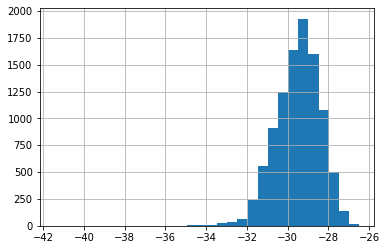

In [35]:
df_mcs_out['23y'].hist(bins=30)

In [1]:
a=[1,2,3,4,5]

In [2]:
a

[1, 2, 3, 4, 5]

In [3]:
[x**2 for x in a]

[1, 4, 9, 16, 25]

In [ ]:
b=[]
for i in range(len(a)):
    b.append(a[i]**2)
